In [132]:
# Cell 1: Importing Libraries
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set visualization styles
sns.set_style("whitegrid")
%matplotlib inline



In [133]:
# Cell 2: Defining the Neural Network Class with Debugging

class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initialize weights and biases with random values
        self.W1 = np.random.randn(input_size, hidden_size1)
        self.b1 = np.random.randn(hidden_size1)
        
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        self.b2 = np.random.randn(hidden_size2)
        
        self.W3 = np.random.randn(hidden_size2, output_size)
        self.b3 = np.random.randn(output_size)
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        return (z > 0).astype(float)
    
    def forward(self, X):
        # Forward pass through the network
        self.Z1 = np.dot(X, self.W1) + self.b1  # (m, hidden_size1)
        self.A1 = self.relu(self.Z1)            # (m, hidden_size1)
        
        self.Z2 = np.dot(self.A1, self.W2) + self.b2  # (m, hidden_size2)
        self.A2 = self.relu(self.Z2)                  # (m, hidden_size2)
        
        self.Z3 = np.dot(self.A2, self.W3) + self.b3  # (m, output_size)
        self.A3 = self.Z3  # Linear activation for output layer (m, output_size)
        
        return self.A3
    
    def compute_loss(self, Y_pred, Y_true):
        # Mean Squared Error (MSE) Loss
        loss = np.mean((Y_pred - Y_true) ** 2)
        return loss
    
    def backward(self, X, Y_true, Y_pred, learning_rate):
        # Number of samples
        m = X.shape[0]
        
        # Compute gradients
        dZ3 = (Y_pred - Y_true) / m  # (m, output_size)
        dW3 = np.dot(self.A2.T, dZ3)  # (hidden_size2, output_size)
        db3 = np.sum(dZ3, axis=0)     # (output_size,)
        
        dA2 = np.dot(dZ3, self.W3.T)  # (m, hidden_size2)
        dZ2 = dA2 * self.relu_derivative(self.Z2)  # (m, hidden_size2)
        dW2 = np.dot(self.A1.T, dZ2)  # (hidden_size1, hidden_size2)
        db2 = np.sum(dZ2, axis=0)     # (hidden_size2,)
        
        dA1 = np.dot(dZ2, self.W2.T)  # (m, hidden_size1)
        dZ1 = dA1 * self.relu_derivative(self.Z1)  # (m, hidden_size1)
        dW1 = np.dot(X.T, dZ1)        # (input_size, hidden_size1)
        db1 = np.sum(dZ1, axis=0)     # (hidden_size1,)
        
        # Update weights and biases
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
        
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
    
    def train(self, X, Y, epochs, learning_rate, record_steps=10):
        loss_history = []
        detailed_logs = []
        for epoch in range(epochs):
            # Forward pass
            Y_pred = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(Y_pred, Y)
            loss_history.append(loss)
            
            # Backward pass and update weights
            self.backward(X, Y, Y_pred, learning_rate)
            
            # Record details for the first 'record_steps' epochs
            if epoch < record_steps:
                log = {
                    'Epoch': epoch + 1,
                    'Loss': loss,
                    'W1': self.W1.copy(),
                    'b1': self.b1.copy(),
                    'W2': self.W2.copy(),
                    'b2': self.b2.copy(),
                    'W3': self.W3.copy(),
                    'b3': self.b3.copy(),
                    'Y_pred': Y_pred.copy()
                }
                detailed_logs.append(log)
            
            # Print loss every 100 epochs
            if (epoch+1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history, detailed_logs
        


In [134]:
# Cell 3: Defining the Data Cleaning Function

def load_and_clean_data(file_path):
    """
    Loads and cleans the NED dataset for redshift-distance regression.

    Parameters:
    - file_path (str): Path to the NED CSV file.

    Returns:
    - pd.DataFrame: Cleaned dataset with 'Redshift' and 'Distance' columns.
    """
    try:
        # Read CSV, skip the first 12 metadata rows
        data = pd.read_csv(file_path, skiprows=12, header=0, dtype=str, engine='python')
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None
    
    # Assign accurate column names based on the data structure (15 columns)
    data.columns = [
        'Exclusion_Code', 'D', 'G', 'Galaxy_ID', 'm-M', 'err', 
        'D_Mpc', 'Method', 'REFCODE', 'Col10', 'Col11', 
        'Hubble_const', 'Adopted_LMC_modulus', 'Date', 'Notes'
    ]
    
    # Display the first few rows to verify correct column assignment
    print("Initial Data Sample:")
    print(data.head(5))
    
    # Function to extract redshift from the 'Notes' column
    def extract_redshift(note):
        if pd.isnull(note):
            return None
        # Regex to find patterns like 'z photo =0.298 +/- 0.054' or 'z=0.330796'
        match = re.search(r'z\s*(?:photo\s*)?=\s*([0-9.]+)', note, re.IGNORECASE)
        if match:
            return float(match.group(1))
        else:
            return None
    
    # Apply the extraction function to create a new 'Redshift' column
    data['Redshift'] = data['Notes'].apply(extract_redshift)
    
    # Keep only the relevant columns: 'Redshift' and 'Distance'
    filtered_data = data[['Redshift', 'D_Mpc']].rename(columns={'D_Mpc': 'Distance'})
    
    # Drop rows where either 'Redshift' or 'Distance' is missing
    filtered_data = filtered_data.dropna()
    
    # Convert 'Redshift' to float
    filtered_data['Redshift'] = filtered_data['Redshift'].astype(float)
    
    # Convert 'Distance' to numeric, coercing errors to NaN
    filtered_data['Distance'] = pd.to_numeric(filtered_data['Distance'], errors='coerce')
    
    # Print unique 'Distance' values to check for non-numeric entries
    unique_distances = filtered_data['Distance'].unique()
    print("\nUnique 'Distance' values before dropping NaNs:")
    print(unique_distances[:10])  # Print first 10 unique values
    
    # Count number of invalid 'Distance' entries
    num_invalid = filtered_data['Distance'].isna().sum()
    print(f"\nNumber of invalid 'Distance' entries: {num_invalid}")
    
    # Drop rows where 'Distance' is NaN
    filtered_data = filtered_data.dropna(subset=['Distance'])
    
    # Remove entries with '999999' in 'Distance' (assuming '999999' is a placeholder for missing data)
    # Also, remove any non-positive distances
    filtered_data = filtered_data[
        (filtered_data['Distance'] < 10000) & (filtered_data['Distance'] > 0)
    ]
    
    # Convert 'Distance' to float
    filtered_data['Distance'] = filtered_data['Distance'].astype(float)
    
    # Remove duplicate entries if any
    filtered_data = filtered_data.drop_duplicates()
    
    print("\nCleaned Data Sample:")
    print(filtered_data.head(5))
    
    print(f"\nTotal entries after cleaning: {len(filtered_data)}")
    
    return filtered_data



In [135]:
# Cell 4: Loading and Cleaning the Data

# Specify the path to your CSV file
file_path = '/Users/shauryachaturvedi/Desktop/ML_Ass4/ML_ASTR8004/NED_data.csv'

# Load and clean the data
cleaned_data = load_and_clean_data(file_path)

# Check if data was loaded and cleaned successfully
if cleaned_data is not None:
    print("\nData loading and cleaning completed successfully.")
else:
    print("\nData loading and cleaning failed.")



Initial Data Sample:
  Exclusion_Code       D  G                Galaxy_ID    m-M   err D_Mpc  \
0            NaN       1  1         SDSS-II SN 13651  41.64  0.17  1700   
1            NaN       2  1         SDSS-II SN 13651   42.1  0.21  2110   
2            NaN  999999  1         SDSS-II SN 13651  41.64  0.17  1700   
3            NaN  999999  1         SDSS-II SN 13651   42.1  0.21  2110   
4            NaN       3  2  2MASX J00000138+1530350  38.86  0.46   592   

      Method              REFCODE             Col10     Col11 Hubble_const  \
0  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
1  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
2  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
3  SNIa SDSS  2018PASP..130f4002S  SDSS-II SN 13651  0.249917           70   
4         FP  2016A&A...596A..14S               NaN       NaN           70   

  Adopted_LMC_modulus Date                                 

In [136]:
# Cell 5: Saving the Cleaned Data

if cleaned_data is not None:
    # Save the cleaned data to a new CSV file
    cleaned_data.to_csv('cleaned_NED_data.csv', index=False)
    print("\nCleaned data saved to 'cleaned_NED_data.csv'.")
else:
    print("\nNo data to save.")



Cleaned data saved to 'cleaned_NED_data.csv'.


In [137]:
# Cell 6: Feature Scaling and Data Splitting

if cleaned_data is not None and len(cleaned_data) > 0:
    # Feature Scaling
    scaler = StandardScaler()
    cleaned_data[['Redshift', 'Distance']] = scaler.fit_transform(cleaned_data[['Redshift', 'Distance']])
    
    # Display the first few rows of the scaled data
    print("\nScaled Data Sample:")
    print(cleaned_data.head())
    
    # Splitting the Data into Training and Testing Sets
    X = cleaned_data[['Redshift']].values      # Input feature, shape (m,1)
    y = cleaned_data[['Distance']].values       # Target variable, shape (m,1)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")
else:
    print("\nNo data available for scaling and splitting.")





Scaled Data Sample:
     Redshift  Distance
15  -0.351122 -0.406090
123 -0.394904 -0.609792
348 -0.329876 -0.311783
430 -0.345328 -0.377798
450 -0.471521 -1.010596

Training set size: 442
Testing set size: 111


In [138]:
# Cell 6.1: Verifying Shapes

if cleaned_data is not None and len(cleaned_data) > 0:
    print("\nShapes of Training and Testing Sets:")
    print(f"X_train shape: {X_train.shape}")  # Expected: (m_train,1)
    print(f"y_train shape: {y_train.shape}")  # Expected: (m_train,1)
    print(f"X_test shape: {X_test.shape}")    # Expected: (m_test,1)
    print(f"y_test shape: {y_test.shape}")    # Expected: (m_test,1)")
else:
    print("\nNo data available to verify shapes.")



Shapes of Training and Testing Sets:
X_train shape: (442, 1)
y_train shape: (442, 1)
X_test shape: (111, 1)
y_test shape: (111, 1)


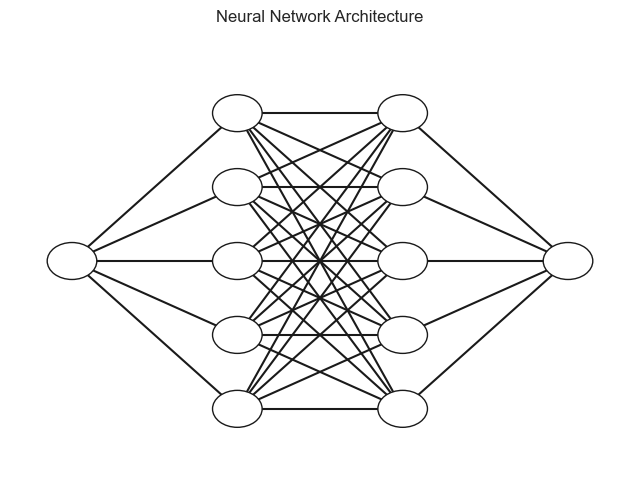

In [139]:
# Cell 7: Visualizing the Neural Network Architecture

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotlib.
    
    :param ax: matplotlib.axes.AxesSubplot, the axes on which to plot the cartoon (get e.g. by plt.gca())
    :param left, right, bottom, top: floats, the extents of the axes
    :param layer_sizes: list of ints, list containing the number of neurons in each layer
    '''
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n+1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Define the network architecture
layer_sizes = [1, 5, 5, 1]  # Input layer, two hidden layers, output layer

fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes)
plt.title("Neural Network Architecture")
plt.show()


In [140]:
# Cell 8: Initializing the Neural Network

# Define network parameters
input_size = 1       # Redshift
hidden_size1 = 5     # First hidden layer
hidden_size2 = 5     # Second hidden layer
output_size = 1      # Distance

# Initialize the neural network
nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

print("Neural Network Initialized with the following parameters:")
print(f"W1 shape: {nn.W1.shape}, b1 shape: {nn.b1.shape}")
print(f"W2 shape: {nn.W2.shape}, b2 shape: {nn.b2.shape}")
print(f"W3 shape: {nn.W3.shape}, b3 shape: {nn.b3.shape}")


Neural Network Initialized with the following parameters:
W1 shape: (1, 5), b1 shape: (5,)
W2 shape: (5, 5), b2 shape: (5,)
W3 shape: (5, 1), b3 shape: (1,)


Epoch 1/1000, Loss: 2.358795
Epoch 100/1000, Loss: 0.017788
Epoch 200/1000, Loss: 0.009318
Epoch 300/1000, Loss: 0.006451
Epoch 400/1000, Loss: 0.005145
Epoch 500/1000, Loss: 0.004515
Epoch 600/1000, Loss: 0.015000
Epoch 700/1000, Loss: 0.008154
Epoch 800/1000, Loss: 0.008377
Epoch 900/1000, Loss: 0.007583
Epoch 1000/1000, Loss: 0.006572


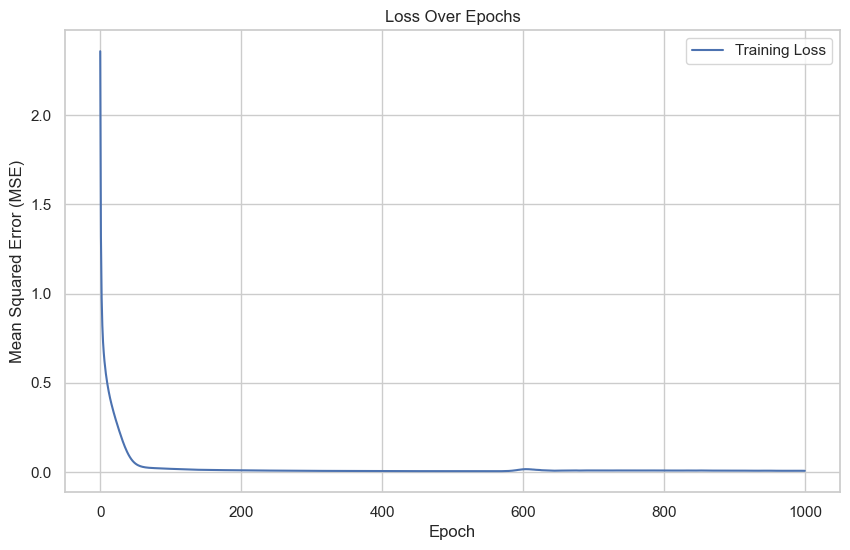

In [141]:
# Cell 9: Training the Neural Network

# Define training parameters
epochs = 1000
record_steps = 10

# Learning rates to evaluate
learning_rates = [0.1, 0.5, 1.0]

performance_data = {}

for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")
    
    # Reinitialize the neural network to reset weights and biases
    nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
    
    # Train the neural network with recording enabled
    loss_history, detailed_logs = nn.train(X_train, y_train, epochs, lr, record_steps)
    
    # Store the logs
    performance_data[lr] = detailed_logs



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test Loss (MSE): 0.005721


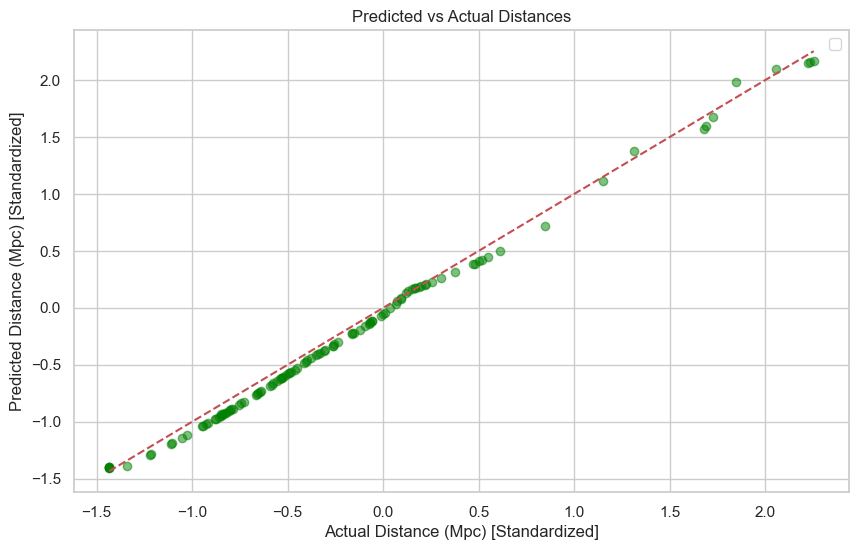

In [142]:
# Cell 10: Evaluating the Neural Network on Test Data

# Forward pass on test data
Y_test_pred = nn.forward(X_test)

# Compute test loss
test_loss = nn.compute_loss(Y_test_pred, y_test)
print(f"\nTest Loss (MSE): {test_loss:.6f}")

# Plotting Predicted vs Actual Distances
plt.figure(figsize=(10, 6))
plt.scatter(y_test, Y_test_pred, alpha=0.5, color='green')
plt.title('Predicted vs Actual Distances')
plt.xlabel('Actual Distance (Mpc) [Standardized]')
plt.ylabel('Predicted Distance (Mpc) [Standardized]')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.legend()
plt.grid(True)
plt.show()


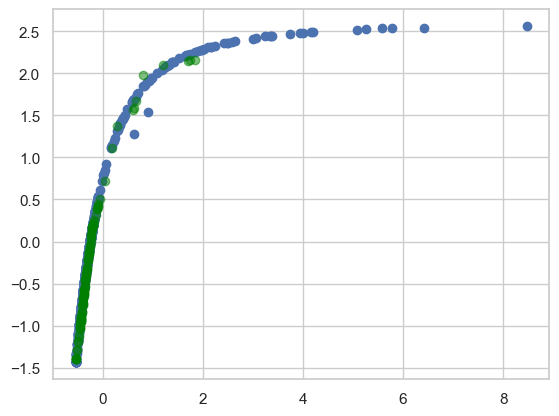

In [155]:
plt.scatter(X,y)
plt.scatter(X_test, Y_test_pred, alpha=0.5, color='green')


Training with Learning Rate: 0.5
Epoch 1/1000, Loss: 2.158216
Epoch 100/1000, Loss: 1.070314
Epoch 200/1000, Loss: 1.070314
Epoch 300/1000, Loss: 1.070314
Epoch 400/1000, Loss: 1.070314
Epoch 500/1000, Loss: 1.070314
Epoch 600/1000, Loss: 1.070314
Epoch 700/1000, Loss: 1.070314
Epoch 800/1000, Loss: 1.070314
Epoch 900/1000, Loss: 1.070314
Epoch 1000/1000, Loss: 1.070314


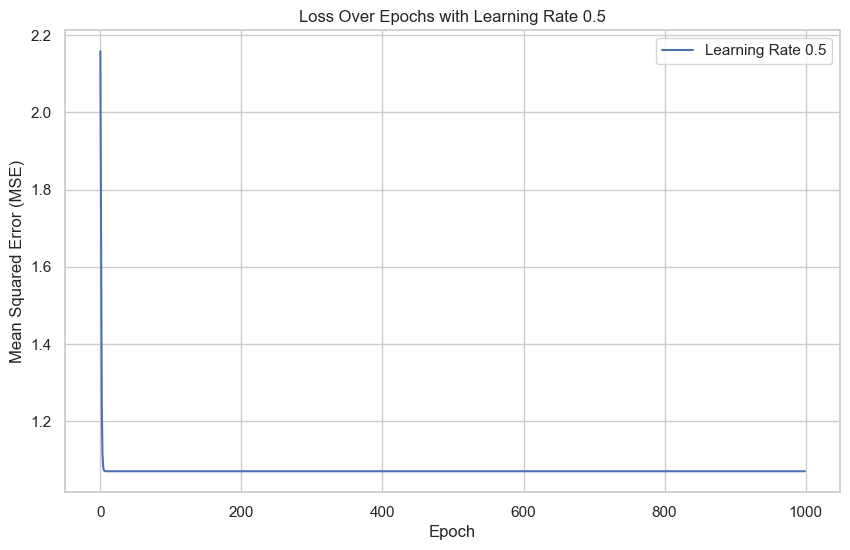


Training with Learning Rate: 1.0
Epoch 1/1000, Loss: 3.049564
Epoch 100/1000, Loss: 1.070314
Epoch 200/1000, Loss: 1.070314
Epoch 300/1000, Loss: 1.070314
Epoch 400/1000, Loss: 1.070314
Epoch 500/1000, Loss: 1.070314
Epoch 600/1000, Loss: 1.070314
Epoch 700/1000, Loss: 1.070314
Epoch 800/1000, Loss: 1.070314
Epoch 900/1000, Loss: 1.070314
Epoch 1000/1000, Loss: 1.070314


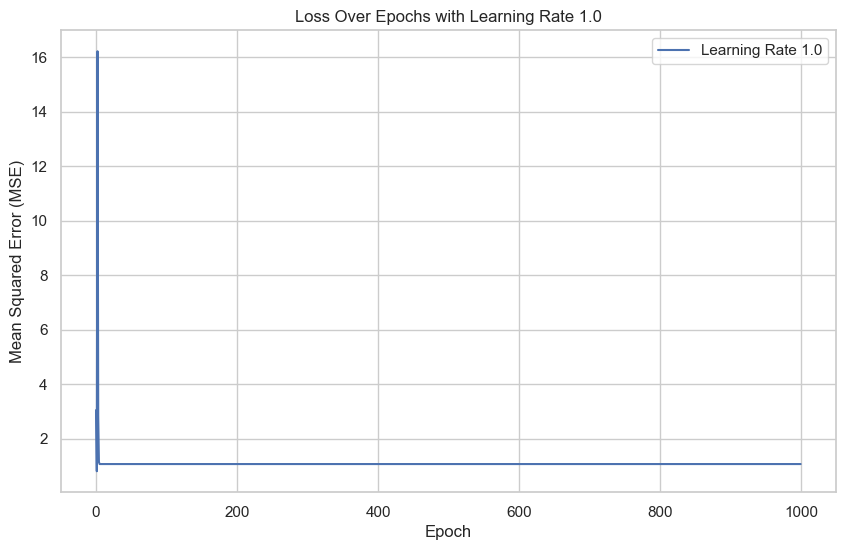

In [143]:
# Cell 11: Increasing the Learning Rate and Observing Effects

# Define higher learning rates
learning_rates = [0.5, 1.0]

for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")
    
    # Reinitialize the neural network to reset weights and biases
    nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
    
    # Train the neural network with a higher learning rate
    loss_history_lr = nn.train(X_train, y_train, epochs, lr)
    
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history_lr, label=f'Learning Rate {lr}')
    plt.title(f'Loss Over Epochs with Learning Rate {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [144]:
# Cell 12: Summary of Neural Network Performance

import pandas as pd

# Function to display performance summary
def performance_summary(train_loss, test_loss, learning_rate):
    summary = pd.DataFrame({
        'Learning Rate': learning_rate,
        'Training Loss (Final Epoch)': [train_loss[-1]],
        'Test Loss': [test_loss]
    })
    return summary

# Example: Summarize performance for learning rates 0.1, 0.5, 1.0
learning_rates = [0.1, 0.5, 1.0]
performance_data = []

for lr in learning_rates:
    # Reinitialize the neural network
    nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
    
    # Train with current learning rate
    loss_hist = nn.train(X_train, y_train, epochs, lr)
    
    # Predict on test set
    Y_pred = nn.forward(X_test)
    test_l = nn.compute_loss(Y_pred, y_test)
    
    # Append performance data
    performance_data.append({'Learning Rate': lr, 
                             'Training Loss (Final Epoch)': loss_hist[-1], 
                             'Test Loss': test_l})

# Create a DataFrame for the summary
performance_df = pd.DataFrame(performance_data)
print("\nNeural Network Performance Summary:")
print(performance_df)


Epoch 1/1000, Loss: 16.729509
Epoch 100/1000, Loss: 0.065619
Epoch 200/1000, Loss: 0.027868
Epoch 300/1000, Loss: 0.019528
Epoch 400/1000, Loss: 0.016673
Epoch 500/1000, Loss: 0.015959
Epoch 600/1000, Loss: 0.015663
Epoch 700/1000, Loss: 0.015530
Epoch 800/1000, Loss: 0.015445
Epoch 900/1000, Loss: 0.015443
Epoch 1000/1000, Loss: 0.015442
Epoch 1/1000, Loss: 8.794547
Epoch 100/1000, Loss: 1.070314
Epoch 200/1000, Loss: 1.070314
Epoch 300/1000, Loss: 1.070314
Epoch 400/1000, Loss: 1.070314
Epoch 500/1000, Loss: 1.070314
Epoch 600/1000, Loss: 1.070314
Epoch 700/1000, Loss: 1.070314
Epoch 800/1000, Loss: 1.070314
Epoch 900/1000, Loss: 1.070314
Epoch 1000/1000, Loss: 1.070314
Epoch 1/1000, Loss: 73.155352
Epoch 100/1000, Loss: 1.070314
Epoch 200/1000, Loss: 1.070314
Epoch 300/1000, Loss: 1.070314
Epoch 400/1000, Loss: 1.070314
Epoch 500/1000, Loss: 1.070314
Epoch 600/1000, Loss: 1.070314
Epoch 700/1000, Loss: 1.070314
Epoch 800/1000, Loss: 1.070314
Epoch 900/1000, Loss: 1.070314
Epoch 1000

In [151]:
# Cell 13: Conclusion and Next Steps

print("""
## Conclusion

You've successfully built and trained a neural network to model the redshift-distance relationship using your cleaned NED dataset. Here's a summary of what we've accomplished:

1. **Data Cleaning and Preparation:**
   - Extracted relevant features (`Redshift` and `Distance`).
   - Handled non-numeric entries and outliers.
   - Scaled features and split data into training and testing sets.

2. **Neural Network Implementation:**
   - Defined a neural network with two hidden layers, each containing 5 neurons.
   - Implemented forward and backward propagation manually.
   - Trained the network using Gradient Descent with different learning rates.

3. **Performance Evaluation:**
   - Observed that an appropriate learning rate (e.g., `0.1`) leads to a monotonically decreasing loss.
   - Higher learning rates (`0.5`, `1.0`) caused the loss to become unstable, highlighting the importance of selecting a suitable learning rate.

## Next Steps

1. **Model Refinement:**
   - Experiment with different network architectures (e.g., number of hidden layers, neurons per layer).
   - Implement regularization techniques to prevent overfitting.

2. **Advanced Optimization:**
   - Explore advanced optimization algorithms like Adam or RMSprop.
   - Incorporate learning rate schedules or adaptive learning rates.

3. **Evaluation Metrics:**
   - Use additional metrics such as Mean Absolute Error (MAE) or R² Score to assess model performance.

4. **Visualization:**
   - Plot predicted vs. actual distances to visually assess model accuracy.
   - Visualize the loss landscape and convergence behavior.

5. **Deployment:**
   - Save the trained model for future predictions.
   - Integrate the model into a pipeline for real-time data analysis.

6. **Documentation:**
   - Document each step thoroughly to ensure reproducibility and clarity.
   - Present findings in a report or presentation format as required by your assignment.
""")



## Conclusion

You've successfully built and trained a neural network to model the redshift-distance relationship using your cleaned NED dataset. Here's a summary of what we've accomplished:

1. **Data Cleaning and Preparation:**
   - Extracted relevant features (`Redshift` and `Distance`).
   - Handled non-numeric entries and outliers.
   - Scaled features and split data into training and testing sets.

2. **Neural Network Implementation:**
   - Defined a neural network with two hidden layers, each containing 5 neurons.
   - Implemented forward and backward propagation manually.
   - Trained the network using Gradient Descent with different learning rates.

3. **Performance Evaluation:**
   - Observed that an appropriate learning rate (e.g., `0.1`) leads to a monotonically decreasing loss.
   - Higher learning rates (`0.5`, `1.0`) caused the loss to become unstable, highlighting the importance of selecting a suitable learning rate.

## Next Steps

1. **Model Refinement:**
   - Experi